## Importing libraries

In [8]:
# 🌐 Computer Vision
import torch
from torch import nn # Neural neutwork components
from torch.utils.data import DataLoader # For batching and loading the data
from torchvision import datasets # To access FashionMNIST
from torchvision.transforms import ToTensor # Convert PIL images to tensors

# 🕒 Utilities
from timeit import default_timer as timer # Training time duration
from tqdm import tqdm
import random

# 📊 Visualization and metrics
import matplotlib.pyplot as plt
import torchmetrics
from torchmetrics import Accuracy, ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

## Importing functions

In [9]:
# Importar las funciones necesarias desde my_functions.py
from my_functions import (
    get_data_transforms,  # Transformaciones para las imágenes
    get_dataloaders,      # Función para cargar DataLoaders
    train_step,           # Paso de entrenamiento
    test_step,            # Paso de prueba
    device,               # Dispositivo (CPU/GPU)
    visualize_predictions # Visualización de predicciones
)


## Training Data

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_data, test_data, train_dataloader, test_dataloader, class_names = get_dataloaders(
    data_dir="../data", 
    batch_size=64,
    num_channels=1
)

## CNN model creation

In [11]:
# 🚀 Here's how we implement a Convolutional Layer in CNN model using PyTorch:
class Model(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        
        # Bloques convolucionales
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Cálculo automático de in_features
        self.flatten = nn.Flatten()
        with torch.no_grad():
            sample_input = torch.randn(1, input_shape, 160, 160)  # Tamaño de imagen de entrada
            conv_output = self.block_2(self.block_1(sample_input))
            flattened_size = conv_output.view(1, -1).size(1)

        # Clasificador
        self.classifier = nn.Sequential(
            self.flatten,
            nn.Linear(in_features=flattened_size, out_features=output_shape)
        )

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

In [14]:
# Inicializar el modelo, el optimizador y el scheduler
model = Model(input_shape=1, hidden_units=6, output_shape=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

# Definir la función de pérdida y métrica
loss_fn = nn.BCEWithLogitsLoss()
accuracy_metric = torchmetrics.Accuracy(task="binary").to(device)

# Entrenamiento del modelo
train_time_start = timer()

epochs = 10
for epoch in tqdm(range(epochs), desc="Training Progress", unit="epoch"):
    # Entrenamiento y evaluación
    train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, accuracy_metric)
    test_loss, test_acc = test_step(model, test_dataloader, loss_fn, accuracy_metric)

    # Actualizar el learning rate con el scheduler
    scheduler.step(test_loss)

    # Mostrar resultados del epoch
    print(f"\n\033[1mEpoch {epoch+1}\033[0m:")
    print(f"🔹 Train loss: {train_loss:.4f}, Train accuracy: {train_acc * 100:.0f}%")
    print(f"🔹 Test loss: {test_loss:.4f}, Test accuracy: {test_acc * 100:.0f}%")

train_time_end = timer()
total_train_time = train_time_end - train_time_start
print(f"\n\033[1mTotal Training Time:\033[0m {total_train_time:.2f} seconds")

Training Progress:  10%|█         | 1/10 [00:29<04:22, 29.20s/epoch]


Epoch 1:
🔹 Train loss: 0.5623, Train accuracy: 71%
🔹 Test loss: 0.6048, Test accuracy: 66%


Training Progress:  20%|██        | 2/10 [00:58<03:52, 29.04s/epoch]


Epoch 2:
🔹 Train loss: 0.4234, Train accuracy: 81%
🔹 Test loss: 0.5458, Test accuracy: 75%


Training Progress:  30%|███       | 3/10 [01:26<03:22, 28.95s/epoch]


Epoch 3:
🔹 Train loss: 0.3331, Train accuracy: 87%
🔹 Test loss: 0.5751, Test accuracy: 78%


Training Progress:  40%|████      | 4/10 [01:56<02:54, 29.06s/epoch]


Epoch 4:
🔹 Train loss: 0.2740, Train accuracy: 90%
🔹 Test loss: 0.5115, Test accuracy: 80%


Training Progress:  50%|█████     | 5/10 [02:25<02:25, 29.09s/epoch]


Epoch 5:
🔹 Train loss: 0.2441, Train accuracy: 91%
🔹 Test loss: 0.4735, Test accuracy: 83%


Training Progress:  60%|██████    | 6/10 [02:54<01:55, 28.97s/epoch]


Epoch 6:
🔹 Train loss: 0.2026, Train accuracy: 93%
🔹 Test loss: 0.4558, Test accuracy: 83%


Training Progress:  70%|███████   | 7/10 [03:23<01:26, 28.99s/epoch]


Epoch 7:
🔹 Train loss: 0.1749, Train accuracy: 94%
🔹 Test loss: 0.5875, Test accuracy: 82%


Training Progress:  80%|████████  | 8/10 [03:52<00:58, 29.03s/epoch]


Epoch 8:
🔹 Train loss: 0.1545, Train accuracy: 95%
🔹 Test loss: 0.4231, Test accuracy: 84%


Training Progress:  90%|█████████ | 9/10 [04:21<00:29, 29.06s/epoch]


Epoch 9:
🔹 Train loss: 0.1395, Train accuracy: 96%
🔹 Test loss: 0.4008, Test accuracy: 87%


Training Progress: 100%|██████████| 10/10 [04:50<00:00, 29.06s/epoch]


Epoch 10:
🔹 Train loss: 0.1246, Train accuracy: 96%
🔹 Test loss: 0.3595, Test accuracy: 84%

Total Training Time: 290.59 seconds


## Check Results

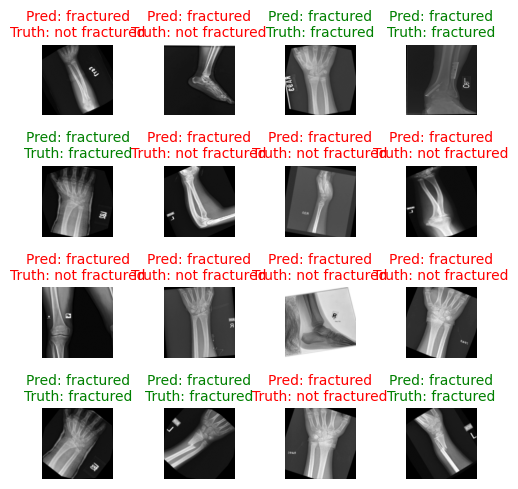

In [13]:
# Visualizar los resultados del modelo
visualize_predictions(
    model=model, 
    test_data=test_data, 
    test_dataloader=test_dataloader, 
    class_names=class_names, 
    device=device
)
